# Implementation of Gibbs sampling in a simple Linear Gaussian model

## Model specifiction
In this exercise, we consider a model with three continuous variables related as illustrated in the Bayesian network model below
<img src="model.png" width=150>
We shall assume that the model is specified as follows:
<ul>
<li> $f(x) = \mathcal{N}(x|\mu_x,\sigma_x^2)$
<li> $f(y|x) = \mathcal{N}(y|x, \sigma^2)$
<li> $f(z|x) = \mathcal{N}(z|x, \sigma^2)$
</ul>
As a starting point, we set the parameters as follows (feel free to experiment with other values)
<ul>
<li> $\mu_x=0$
<li> $\sigma_x^2=1$
<li> $\sigma^2 = 1$
</ul>
and assume that we observe $z=2$.

### Import libraries
We use `import` to get access to libraries that are not originally there for us. Download them to your computer using `pip install`, then load them into the program with `import`.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal, norm, gaussian_kde

### Set the model parmeters according to the specification above

In [2]:
# The mean for x
mu_x = 0

# The std.dev for x, y and z (y and z have the same variance, called `sigma`)
sigma_x = 1
sigma = 2

# The observed value for z
obs_z = 2

# Then we set the seed for the sampler, just to controlwhat goes on
np.random.seed(123)

# Gibbs sampler

For implementing the Gibbs sampler for the example above, we need $f(x|y,z)$ and $f(y|x,z)$. The latter is easy, since the model's independence assumptions imply that
$$ f(y|x,z) = f(y|x),$$
which we get from the model specification above.

With a bit of pencil pushing, we can derive the following expression for $f(x|y,z)$:
$$
f(x|y,z) = \mathcal{N}\left(x|\frac{\sigma_x^2}{\sigma_x^2 + \sigma^2/2}\cdot \frac{y+z}{2} + \frac{\sigma^2/2}{\sigma_x^2 + \sigma^2/2}\cdot \mu_x, \left (\frac{1}{\sigma_x^2} + \frac{2}{\sigma^2}\right )^{-1}\right ).
$$
That is, the conditional mean is $\frac{\sigma_x^2}{\sigma_x^2 + \sigma^2/2}\cdot \frac{y+z}{2} + \frac{\sigma^2/2}{\sigma_x^2 + \sigma^2/2}\cdot \mu_x$, and the conditional variance is 
$\left(\frac{1}{\sigma_x^2} + \frac{2}{\sigma^2}\right )^{-1}$.

## Initialize Gibbs sampler

In [3]:
# The number of samples to generate
num_iter = 20000

# The burn - in specifies the number of samples to discard before calculating relevant statistics from 
# the generated samples. This is to ensure that "silly" starting position from teh chain does not interfer
# with the generated results.
burn_in = 50

# The data structure holding the x samples is an array defined by the numpy lib. 
# We generate it by simply allocating zeros
# The first entry is initilized by a random sample 
# from a standard normal distribution. 
x_samples = np.zeros(num_iter + 1)
x_samples[0] = np.random.normal(loc=0, scale=1)

# The index of the most recently sampled value for x
last_x_idx = 0

# The data structure holding the y samples is again a numpy array. 
# The first entry is initilized by a random sample 
# from a standard normal distribution
y_samples = np.zeros(num_iter + 1)
y_samples[0] = np.random.normal(loc=0, scale=1)


# The index of the most recently sampled value for y
last_y_idx = 0

## Sample value for x
`def sample_x` is the Python def of a function named `def sample_x`. It does not take any inputs

In [4]:
def sample_x():
    # We use the last_x_idx, and define it as global to ensure it is the same as the outer scope 
    global last_x_idx
        
    # Mean of the observed value for z and the last sampled value for y 
    sample_mean = (obs_z + y_samples[last_y_idx])/2
    
    # Posterior mean
    mean = sigma_x/(sigma_x + sigma/2) * sample_mean + .5*sigma/(sigma_x + .5*sigma) * mu_x
    
    # Posterior variance
    var = 1.0/(1/sigma + 2/sigma)
    
    # Increment counter 
    last_x_idx = last_x_idx + 1
    
    # Sample value, and put in the list
    x_samples[last_x_idx] = np.random.normal(loc=mean, scale=np.sqrt(var))

## Sample value for y
We define a similar function for sampling $Y$

In [5]:
def sample_y():
    global last_y_idx
    last_y_idx = last_y_idx + 1
    y_samples[last_y_idx] = np.random.normal(loc=x_samples[last_x_idx], scale=np.sqrt(sigma))

## Run the samler
Now we are ready, sample $X_{t+1}$ conditioned on the values  $\{Z=z, Y=y_t\}$, 
then $Y_{t+1}$ based on values  $\{Z=z, X=X_{t+1}\}$. 

In [6]:
for i in range(num_iter):
    sample_x()
    sample_y()

## Summary statistics

### Approximate values
Print out a couple of summary statistics. numpy provides us with these functionalities directly

In [7]:
# Mean and marginal variance for X and Z
mean_x = np.mean(x_samples[burn_in:])
print("Mean(x) = {} ".format(mean_x))
var_x = np.var(x_samples[burn_in:])
print("Var(x) = {} ".format(var_x))
mean_y = np.mean(y_samples[burn_in:])
print("Mean(y) = {} ".format(mean_y))
var_y = np.var(y_samples[burn_in:])
print("Var(y) = {} ".format(var_y))

# Covariance
print("Approximate covariance:")
cov = np.cov([x_samples[burn_in:], y_samples[burn_in:]])
print(cov)

Mean(x) = 0.6801227074213162 
Var(x) = 0.8529865148077755 
Mean(y) = 0.6885450403445229 
Var(y) = 2.850362487517844 
Approximate covariance:
[[0.85302927 0.8620979 ]
 [0.8620979  2.85050536]]


### Exact values
We can find the posterior exactly by just some pencil pushing. The values are as follows:

In [8]:
true_post_mean_x = sigma_x/(sigma_x + sigma) * obs_z + sigma/(sigma_x + sigma) * mu_x
print("True posterior mean for x: {}".format(true_post_mean_x))
true_post_var_x = 1.0/(1/sigma_x + 1/sigma)
print("True posterior variance for x: {}".format(true_post_var_x))
true_post_mean_y = sigma_x/(sigma_x + sigma) * obs_z + sigma/(sigma_x + sigma) * mu_x
print("True posterior mean for x: {}".format(true_post_mean_y))
true_post_var_y = true_post_var_x + sigma
print("True posterior variance for x: {}".format(true_post_var_y))

True posterior mean for x: 0.6666666666666666
True posterior variance for x: 0.6666666666666666
True posterior mean for x: 0.6666666666666666
True posterior variance for x: 2.6666666666666665


### Estimation errors

In [9]:
print("Absolute error of mean for x: {}".format(np.abs(true_post_mean_x)-mean_x))
print("Absolute error of variance for x: {}".format(np.abs(true_post_var_x)-var_x))
print("Absolute error of mean for y: {}".format(np.abs(true_post_mean_y)-mean_y))
print("Absolute error of variance for y: {}".format(np.abs(true_post_var_y)-var_y))

Absolute error of mean for x: -0.013456040754649568
Absolute error of variance for x: -0.1863198481411089
Absolute error of mean for y: -0.021878373677856278
Absolute error of variance for y: -0.18369582085117742


## Some basic plotting

In [10]:
def density_plt(loc, cov):
    x = np.linspace(np.min(x_samples), np.max(x_samples), 100)
    y = np.linspace(np.min(y_samples), np.max(y_samples), 100)
    x_mesh, y_mesh = np.meshgrid(x, y)
    pos = np.empty(x_mesh.shape + (2,))
    pos[:, :, 0] = x_mesh
    pos[:, :, 1] = y_mesh

    rv = multivariate_normal(loc, cov)
    plt.contour(x, y, rv.pdf(pos), colors='b')

### We only plot every 10th sample and overlay with the estimated density 

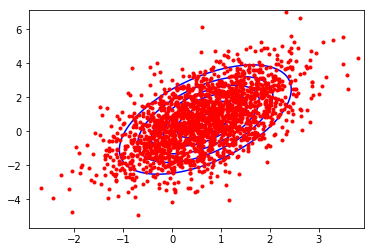

In [11]:
# Notive the notation here. We "slice" a vector using x[a:b] to get elements starting 
# from <a> and going up to but not including <b>. Thus, x_samples[burn_in:] would discard the 
# first <burn_in> elements. The aditional ":10" says we only want every tenth sample. 
# This is to avoid clutter here, but is sometimes also used to reduce auto-correlation 
# in the sampled sequence.

plt.plot(x_samples[burn_in::10], y_samples[burn_in::10],'.r')
density_plt([mean_x, mean_y], cov)

### Finally, plot tkhe kernel density approximation for $Y|Z=z$ and compare to the exact one
We generate the kernel density by relying on `gaussian_kde`from `scipy`, and compare the approximation (in blue)
to the exact result (with pdf calculation again picked out of `scipy`.

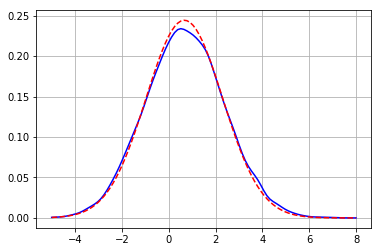

In [12]:
kernel = gaussian_kde(y_samples[burn_in:])
x_axis_values = np.linspace(-5,8,100)
plt.plot(x_axis_values, kernel(x_axis_values), 'b-')
plt.plot(x_axis_values, norm.pdf(x_axis_values, loc=true_post_mean_y, scale=np.sqrt(true_post_var_y)), 'r--')
plt.grid(True)
plt.show()
                                      